In [115]:
%load_ext autoreload
%autoreload 2

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import activity_classifier as ac
from activity_classifier import ChunkableTimeSeries, CAP24_DIR
from activity_classifier import sigproc

from scipy import signal

matplotlib.style.use('ggplot')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


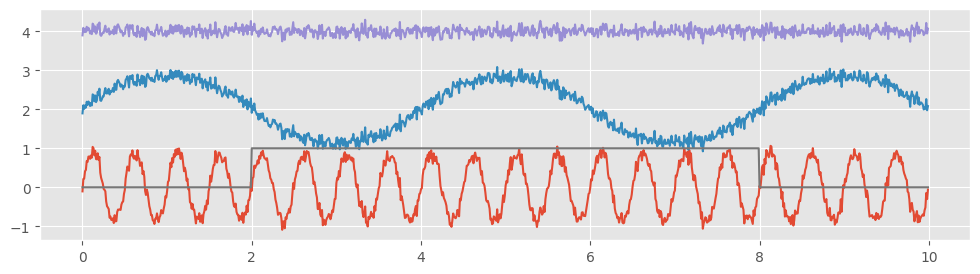

In [116]:
# Generate and plot sim data

t = np.arange(0, 10, 0.01)
x = np.sin(np.sin(2 * (2*np.pi*t))) # 2 hz
y = np.sin(np.sin(0.25 * (2*np.pi*t))) + 2 # 0.25 hz
z = (0 * t) + 4

noise = np.random.normal(size=x.shape, scale=0.1)
x = x + noise
y = y + noise
z = z + noise

# Annotation
a = np.array([0] * 200 + [1] * 600 + [0] * 200)

fig, ax = plt.subplots(figsize=(12, 3))
ax.plot(t, x)
ax.plot(t, y)
ax.plot(t, z)
ax.plot(t, a)
#ax.set_xlim(0, 1)
plt.show()

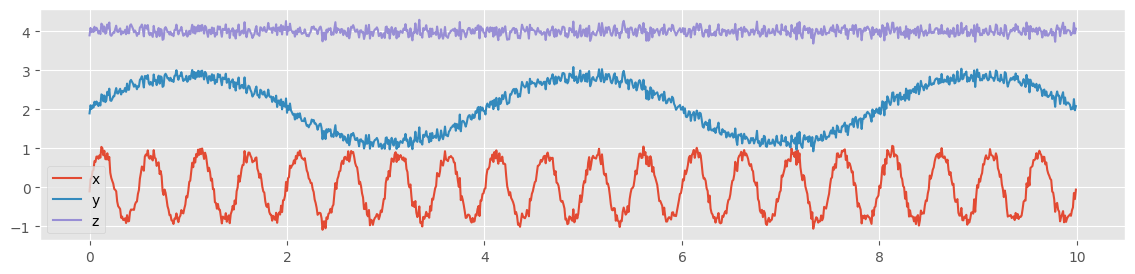

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

In [117]:
df = pd.DataFrame({
    'timestamp': t,
    'x': x,
    'y': y,
    'z': z,
    'annotation': a
})
cts = ChunkableTimeSeries(df, metadata={'subject_id': 'test'})
cts.plot()

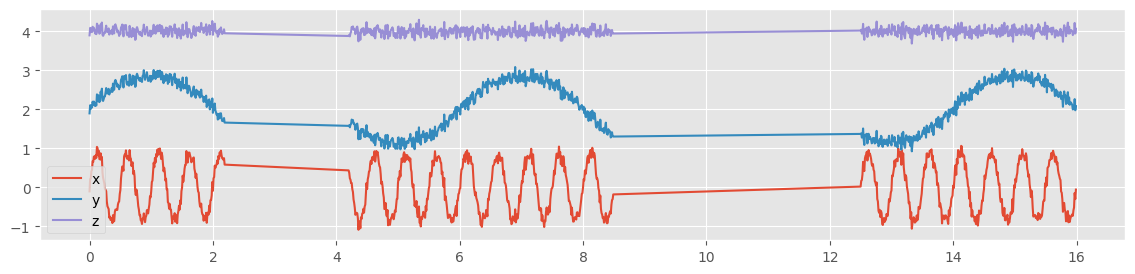

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

In [118]:
# Add gaps
cts.df.loc[220:, 'timestamp'] = cts.df.loc[200:, 'timestamp'] + 2
cts.df.loc[650:, 'timestamp'] = cts.df.loc[650:, 'timestamp'] + 4
cts.refresh()
cts.plot()

5
[200, 200, 200, 200, 200]


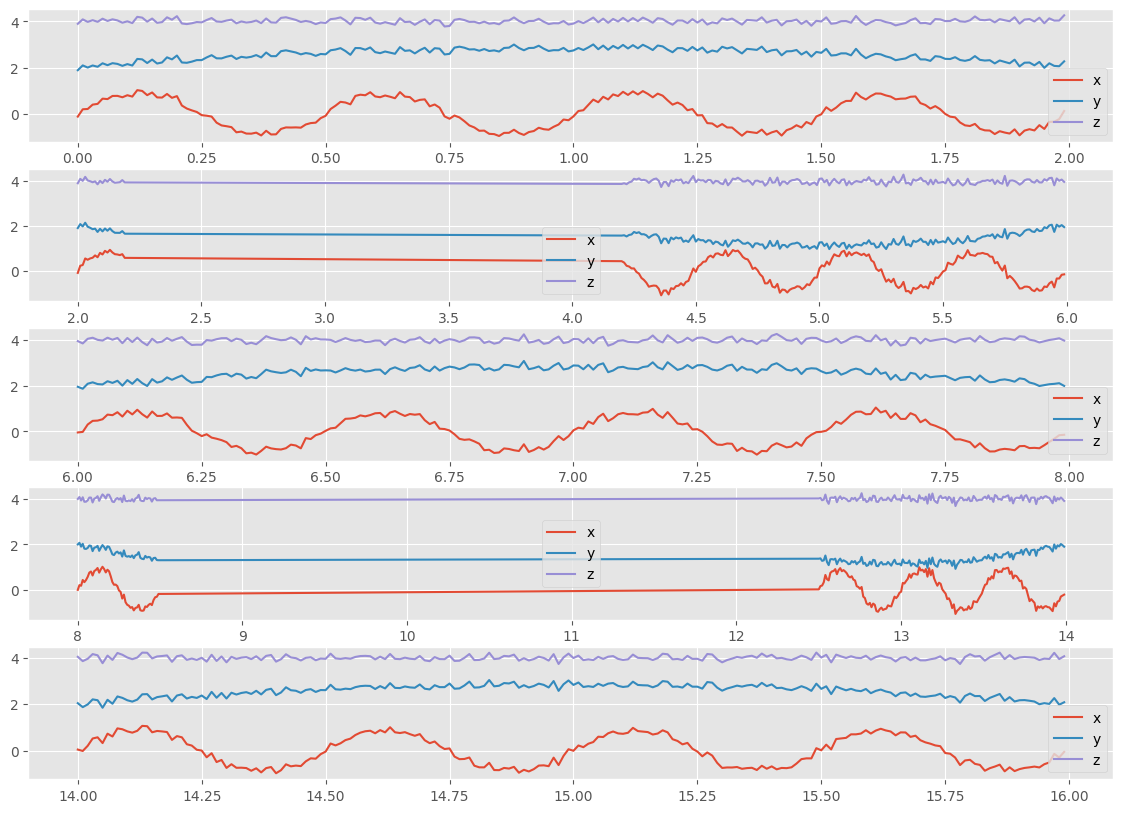

5
[220, 220, 220, 220, 120]
4
[220, 220, 220, 220]


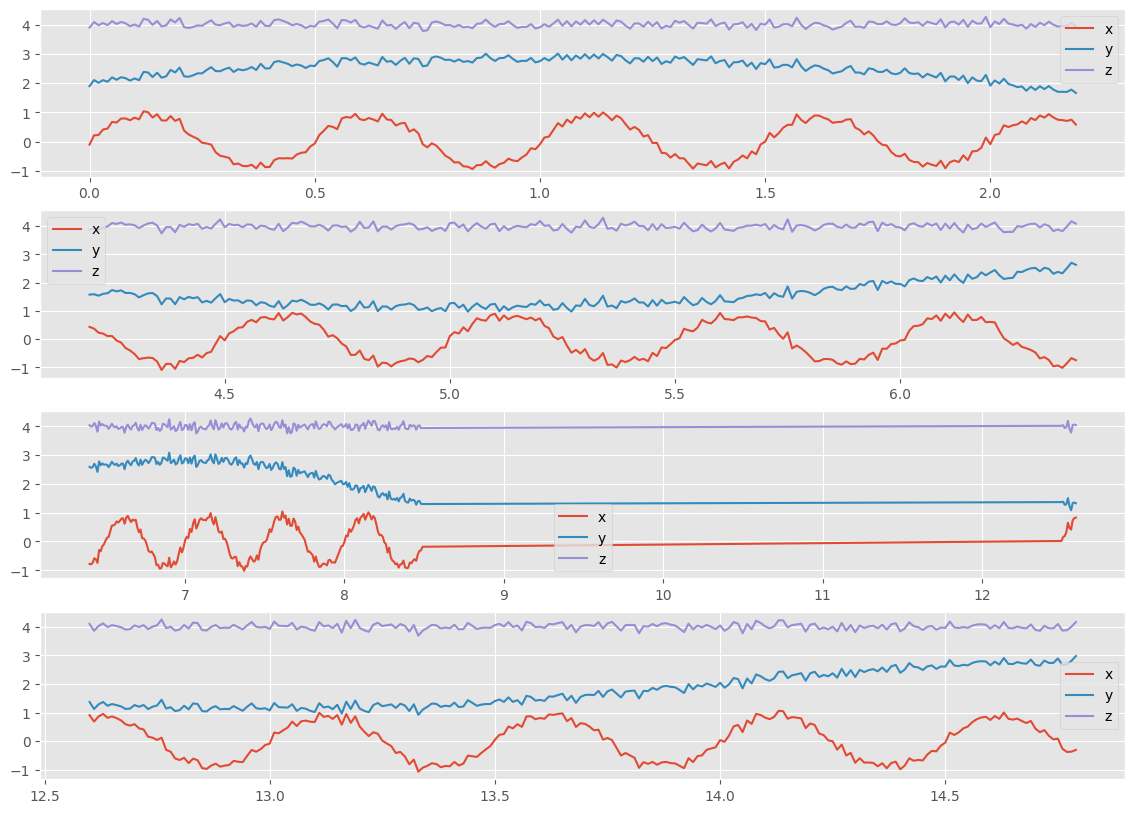

In [119]:
# Check get_chunks_by_samples
chunks = cts.get_chunks_by_samples(chunk_size=200)
print(len(chunks))
print([len(c) for c in chunks])

fig, axes = plt.subplots(figsize=(14, 10), nrows=len(chunks), ncols=1)
for i, ax in enumerate(axes):
    chunks[i].plot(ax=ax, show_plot=False)
plt.show()

chunks = cts.get_chunks_by_samples(chunk_size=220, min_n=None)
print(len(chunks))
print([len(c) for c in chunks])

chunks = cts.get_chunks_by_samples(chunk_size=220, min_n=200)
print(len(chunks))
print([len(c) for c in chunks])

fig, axes = plt.subplots(figsize=(14, 10), nrows=len(chunks), ncols=1)
for i, ax in enumerate(axes):
    chunks[i].plot(ax=ax, show_plot=False)
plt.show()


[200, 20, 180, 200, 50, 150, 200]
1000


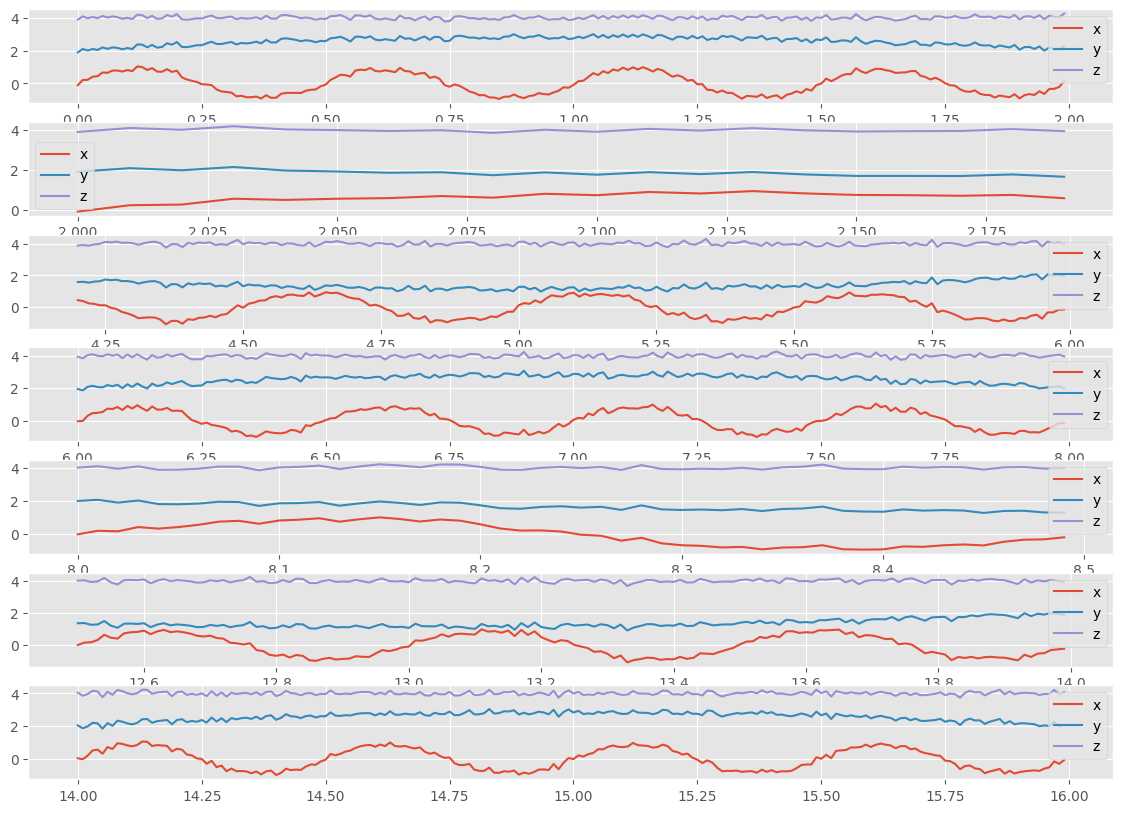

In [120]:
# Check get_chunks_by_time
chunks = cts.get_chunks_by_time(chunk_duration=2.)

fig, axes = plt.subplots(figsize=(14, 10), nrows=len(chunks), ncols=1)
for i, ax in enumerate(axes):
    chunks[i].plot(ax=ax, show_plot=False)

lengths = [len(c) for c in chunks]
print(lengths)
print(sum(lengths))


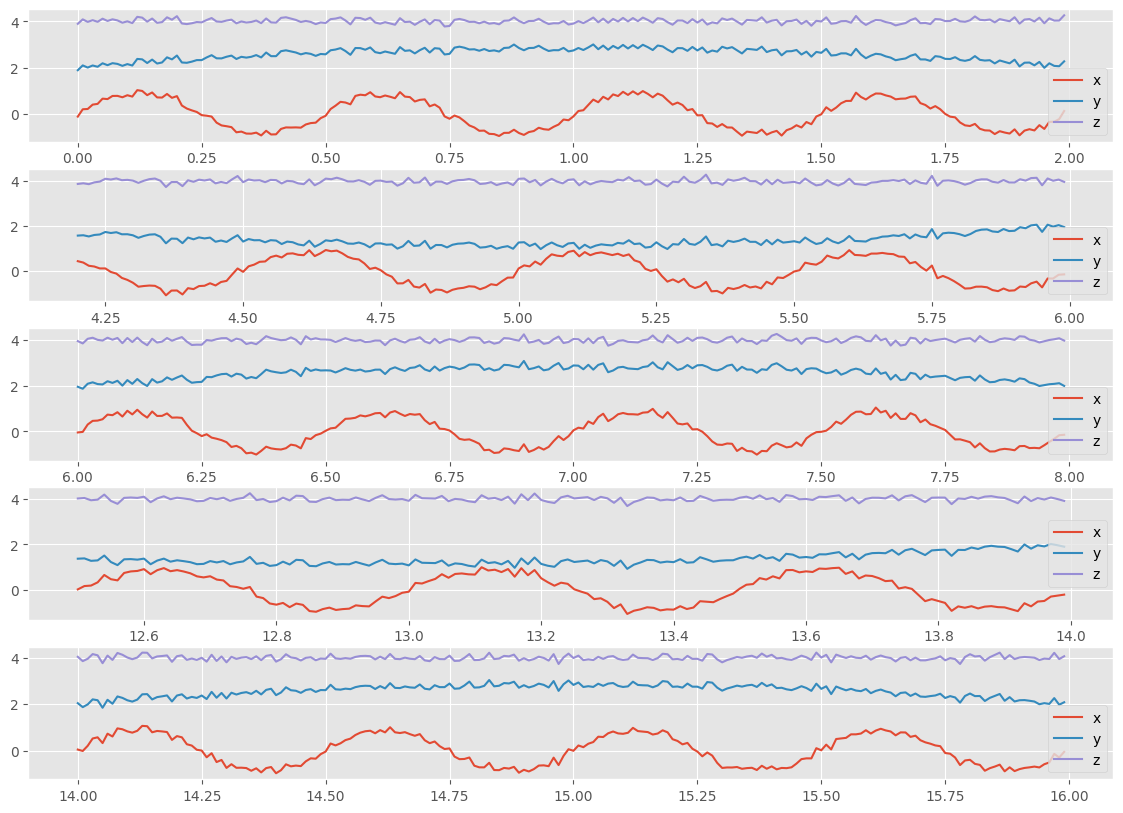

In [121]:
# Check get_chunks_by_time, adding min_dur
chunks = cts.get_chunks_by_time(chunk_duration=2, min_dur=1)

fig, axes = plt.subplots(figsize=(14, 10), nrows=len(chunks), ncols=1)
for i, ax in enumerate(axes):
    chunks[i].plot(ax=ax, show_plot=False)

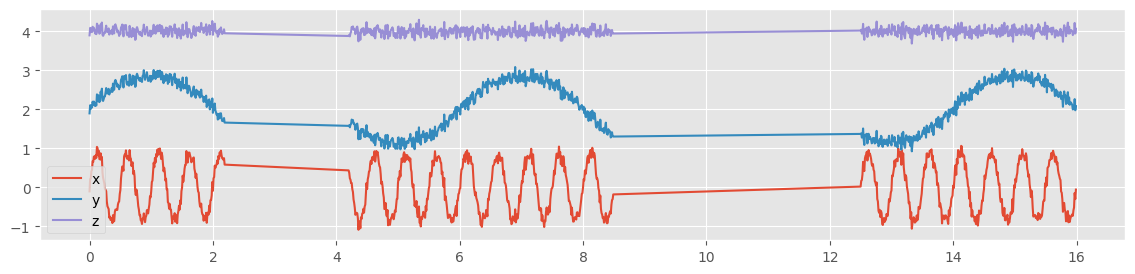

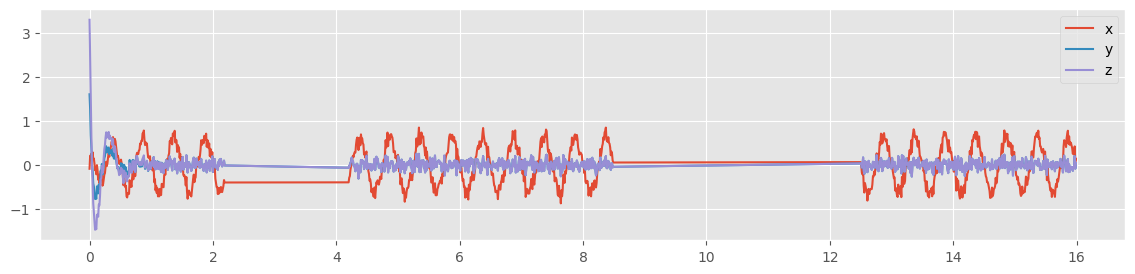

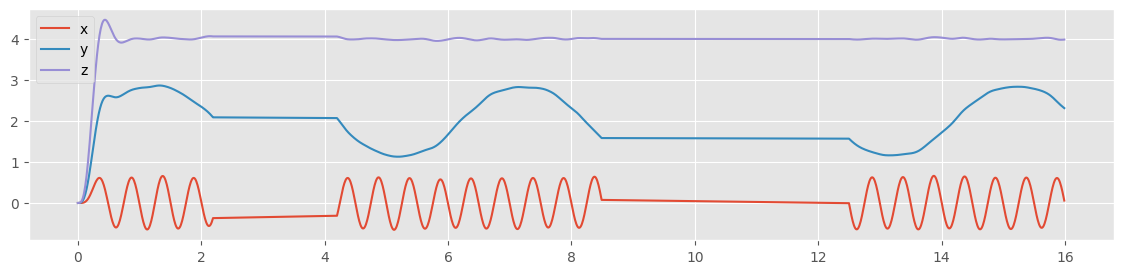

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

In [122]:
# Test filters
hp = sigproc.SmartIIRFilter(
    signal.butter,
    btype='highpass',
    order=4,
    cutoff=2,
    fs=100
)
lp = sigproc.SmartIIRFilter(
    signal.butter,
    btype='lowpass',
    order=4,
    cutoff=2,
    fs=100
)

cts_hp = cts.apply_smart_filter(hp, inplace=False)
cts_lp = cts.apply_smart_filter(lp, inplace=False)

cts.plot()
cts_hp.plot()
cts_lp.plot()

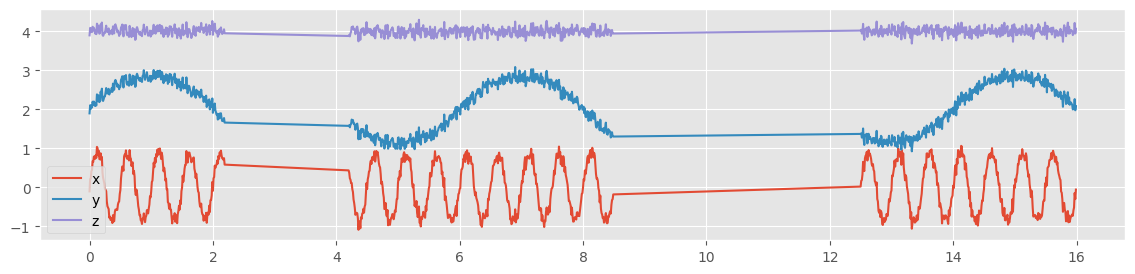

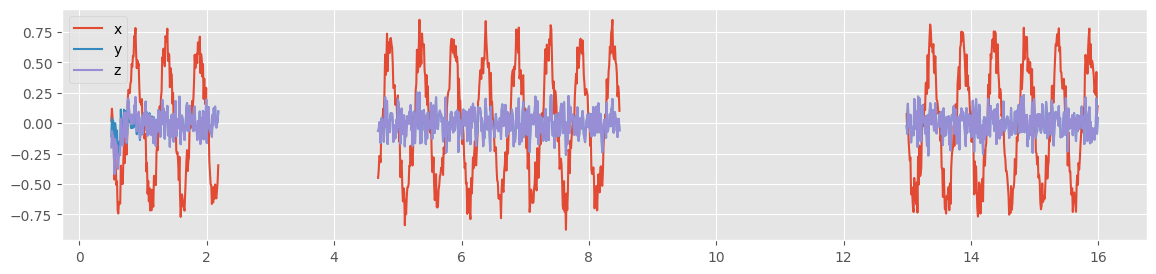

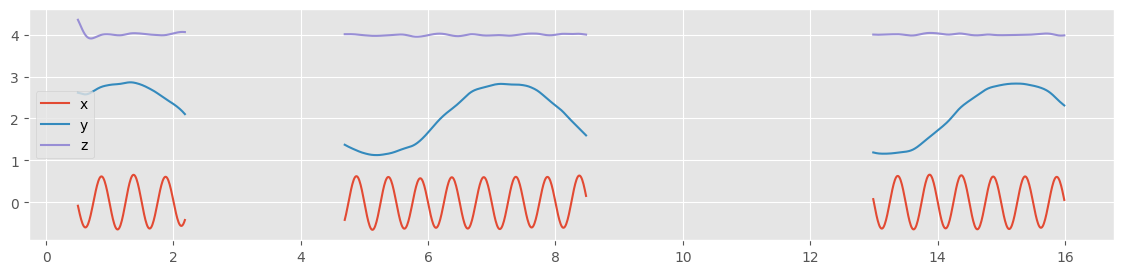

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

In [123]:
# Test filters with gap limits and transient drops
hp = sigproc.SmartIIRFilter(
    signal.butter,
    btype='highpass',
    order=4,
    cutoff=2,
    fs=100,
    transient_t=0.5,
    max_t_gap=0.5
)
lp = sigproc.SmartIIRFilter(
    signal.butter,
    btype='lowpass',
    order=4,
    cutoff=2,
    fs=100,
    transient_t=0.5,
    max_t_gap=0.5
)

cts_hp = cts.apply_smart_filter(hp, inplace=False)
cts_lp = cts.apply_smart_filter(lp, inplace=False)

cts.plot()
cts_hp.plot()
cts_lp.plot()

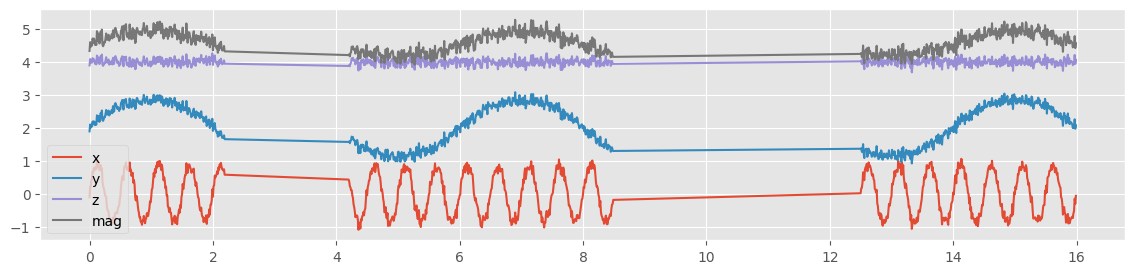

(<Figure size 1400x300 with 1 Axes>, <Axes: >)

In [124]:
# Check calc_vector_magnitude
cts.calc_vector_magnitude()
cts.calc_vector_magnitude() # Second call does nothing
cts.plot()


In [110]:
# Load from file, get 10-sec chunks
dff = ac.load_acc_data_file()

/Users/bryanfry/code/activity-classifier/activity_classifier/__init__.py:171: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  '''


In [114]:
ctsf = ChunkableTimeSeries(dff)
chunks = ctsf.get_chunks_by_time(chunk_duration=10)

durs = [c.get_duration() for c in chunks]
print(len(durs))
print(sum(durs))
print(sum(durs) + len(durs) * 0.01)
print(ctsf.get_duration())
lengths = [len(c) for c in chunks]
print(sum(lengths))
print(len(ctsf))


10020
100099.80009555817
100200.00009555816
100200.0
10020000
10020001
